1754


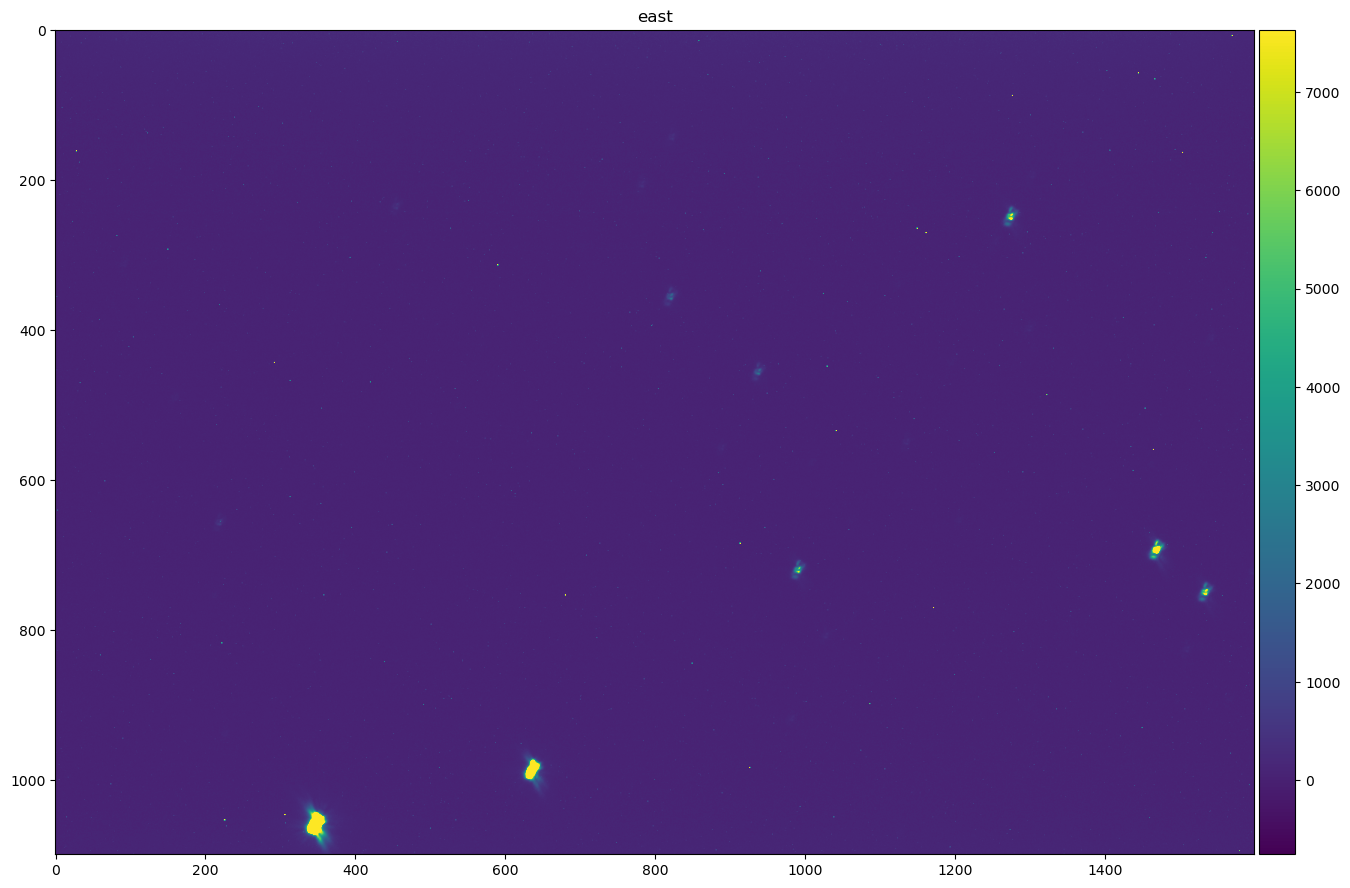

In [29]:
from plotimg import plot_images
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

back = Image.from_file("/data/lvm/sci/agcam/east/20221026/lvm.sci.agcam.east_00000009.fits")
img = Image.from_file("/data/lvm/sci/agcam/east/20221026/lvm.sci.agcam.east_00001275.fits")

#img.data = back.data

#source_detection = SepSourceDetection(threshold= 4.0, minarea=20.0)
source_detection = SepSourceDetection()

img_det = await source_detection(img)

print(len(img_det.catalog))
plot_images([img])


In [35]:

img_det.catalog.sort("fwhm")
img_det.catalog.reverse()
img_det.catalog[img_det.catalog["fwhm"] > 6.0]

x,y,peak,flux,fwhm,a,b,theta,ellipticity,tnpix,kronrad,fluxrad25,fluxrad50,fluxrad75,xwin,ywin
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
1270.7671154764887,260.2107033014467,2229.947021484375,893834.1545913699,15.05215909324473,7.612861633300781,4.8745551109313965,90.0,0.35969477106890635,546,1.82363852950794,7.785701654584482,11.039154970361796,14.955305891873923,1273.7508525362193,249.69151279688901
637.0442165421908,987.1475435833712,65394.5546875,8358331.199051209,14.109415601242667,6.931098461151123,4.874548435211182,90.0,0.29671343402015204,2518,1.1687223093519779,3.42238893143284,5.287027760266785,8.830512262900662,635.9998644522058,986.9589143478177
987.4092908783542,730.5918403919022,1593.208251953125,614951.0687947083,14.067418114551607,7.194775581359863,4.428289413452148,90.0,0.3845131980315124,476,1.9133380879613977,7.304371827851903,10.514838966654514,14.459662142699843,990.3615986348408,720.7463193832832
1469.4818942851714,694.1880025962279,32298.607421875,2042810.6045336912,12.885877442548725,6.326898574829102,4.456313610076904,90.0,0.29565591144358183,1347,1.2349320464254314,3.214320585171487,4.966183341917187,8.734235824942978,1468.4241319577898,694.059319903729
1530.4460478697442,760.487158767043,2425.898193359375,866698.6302841187,11.772930176493817,6.362198829650879,3.0842323303222656,90.0,0.5152254098145639,444,2.2601625144297635,7.447949496838851,10.521008777797359,14.180191521171748,1533.3038874822157,750.3260401423921
1534.4788400191026,753.4032981786692,14009.7392578125,851170.8023843379,10.656219687882793,5.397275447845459,3.438856363296509,90.0,0.3628532772643154,354,1.4665930789656942,3.1695264265241327,5.5783379117135174,8.812364104224738,1533.3815119867227,750.3283451920066
938.1158037693356,459.7632037909912,2777.03515625,177222.9869537354,10.638119547588015,5.251075267791748,3.6391632556915283,90.0,0.30696798843983863,320,1.47116575305684,3.1476332597811414,5.430770789311996,8.456445636335076,937.1363360443924,456.7415624876346
219.13534266388478,649.8534564652931,353.67340087890625,60816.10069686886,10.388305286768047,5.519048690795898,2.909104824066162,90.0,0.4728974163758207,93,2.39018993752299,7.129809540778584,10.051270860499743,13.609110298688687,218.87552271749172,657.4752164801722
992.8584318077158,719.6861615662147,7130.40771484375,590886.2169599917,9.385879704638736,4.589816093444824,3.272162675857544,90.0,0.28708196380006445,238,1.7599772430240135,3.616727046735816,5.63799838350707,8.769056490957377,990.4395222167176,720.8047471668862
